# undistort_stereo
ピンホールカメラモデルを使用してステレオカメラキャリブレーション、視差画像推定、三次元復元を行うNotebookです。`undistort.ipynb`では片方ずつのカメラ画像を処理していましたが、今回は左右両方のカメラ画像からステレオカメラの向きや位置関係を推定します。後半では推定したカメラの位置関係と画像をもとに物体とカメラの距離を推定します。

`undistort.ipynb`と同様にピンホールカメラモデルがベースとなっているため推定に使用できる画角に制限があります。魚眼カメラモデルを用いたものは`undistort_fisheye_stereo.ipynb`になります。

## キャリブレーション手順
1. 事前に`undistort/undistort_data_collection.ipynb`を実行してキャリブレーション用画像を撮影します
1. `undistort/chess_images_stereo`ディレクトリに撮影したキャリブレーション画像があることを確認します
1. セルを順に実行し視差画像が作成されれば完了です

* 参考
    * [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.3.0/d9/d0c/group__calib3d.html)

## カメラキャリブレーション
下記に続くセルを順に実行していきます。まずは必要なPythonモジュールを読み込みます。

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
np.set_printoptions(threshold=5)

キャリブレーション用画像を読み込みます。セルを実行すると画像のファイルパスが一覧になって表示されることをご確認ください。

In [2]:
imgs_dir_l = sorted(glob.glob(os.path.join('chess_images_stereo', '*left*.jpg')))
imgs_dir_r = sorted(glob.glob(os.path.join('chess_images_stereo', '*right*.jpg')))

print(imgs_dir_l)
print(imgs_dir_r)

['chess_images_stereo/326b47e2-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/3b0da6d8-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/427dad0a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4554d9f4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/47d3933c-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4a22d03a-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4e3a0d00-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/4fd662d0-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/6e016e94-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/75c66224-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/7bed500e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/829f2b8e-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/84d572b4-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/8670ed42-b946-11eb-8745-16f63a1aa8c9_left.jpg', 'chess_images_stereo/883ebe06-b94

チェスボードの角(格子点)の数とマスの辺の長さを`camera_config.xml`から読み込みます。

In [3]:
tree = ET.parse("../camera_param/camera_config.xml")
root = tree.getroot()
v_num = int(root.find("board_param").find("v_num").text) # 横方向の格子点数
h_num = int(root.find("board_param").find("h_num").text) # 縦方向の格子点数
chess_size = float(root.find("board_param").find("chess_size").text) # チェッカーパターン１マスあたりの長さ[mm]

キャリブレーションに必要なobject pointsを作成します。object poiintsはワールド座標系におけるチェスボードの格子点の位置です。撮影対象の奥行きを計測する際に画像と現実の縮尺情報が必要になるのでobject pointsにチェスボードのマスの大きさが反映されています。

In [4]:
object_point = np.zeros((v_num*h_num, 3), np.float32)
object_point[:, :2] = np.mgrid[0:v_num, 0:h_num].T.reshape(-1,2) * chess_size

object_points = [] # 上述したobject_pointの集まり（3次元ベクトルのリスト）
img_points_l = [] # 左カメラの画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）
img_points_r = [] # 右カメラの画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）

次のステップでチェスボードの格子点を検出するので、検出結果をわかりやすく描画するための関数を作成しておきます。

In [5]:
def reserveCorners(img, corners, img_points, imgs):
    corners_subpix = cv2.cornerSubPix(img, corners, (11, 11), (-1, -1), criteria)
    img_points.append(corners_subpix)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    imgs.append(cv2.drawChessboardCorners(img, (v_num, h_num), corners_subpix, True))

各キャリブレーション用画像からチェスボードの格子点を検出し、`img_points`に保存します。`img_points`の位置関係からカメラの歪み具合が推定できます。`img_points`が二次元画像上の格子点の位置を保存し、`object_points`が三次元空間上の格子点の位置を保存しています。

In [6]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # 反復アルゴリズムの終了基準の指定
imgs_l = [] # 左カメラの画像表示用
imgs_r = [] # 右カメラの画像表示用

for img_dir_l, img_dir_r in zip(imgs_dir_l, imgs_dir_r):
    img_l = cv2.imread(img_dir_l, cv2.IMREAD_GRAYSCALE)
    img_r = cv2.imread(img_dir_r, cv2.IMREAD_GRAYSCALE)
    ret_l, corners_l = cv2.findChessboardCorners(img_l, (v_num, h_num), None) # 左カメラ画像から格子点を探す（ピクセル単位）
    ret_r, corners_r = cv2.findChessboardCorners(img_r, (v_num, h_num), None) # 右カメラ画像から格子点を探す（ピクセル単位）
    if ret_l == True and ret_r == True: # 左右両方の画像から検出に成功した場合のみ、その結果を保存する
        object_points.append(object_point)
        reserveCorners(img_l, corners_l, img_points_l, imgs_l)
        reserveCorners(img_r, corners_r, img_points_r, imgs_r)

チェスボードの格子点が正しく検出されているか確認するため、検出結果を表示する関数を作成します。

In [7]:
def gridShow(imgs):
    img_num = len(imgs)
    col = 3
    row = np.ceil(img_num / col)
    fig = plt.figure(figsize=(18, 4*row))
    for i, img in enumerate(imgs):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis = fig.add_subplot(row, col, i + 1)
        axis.imshow(img)
        i = i + 1

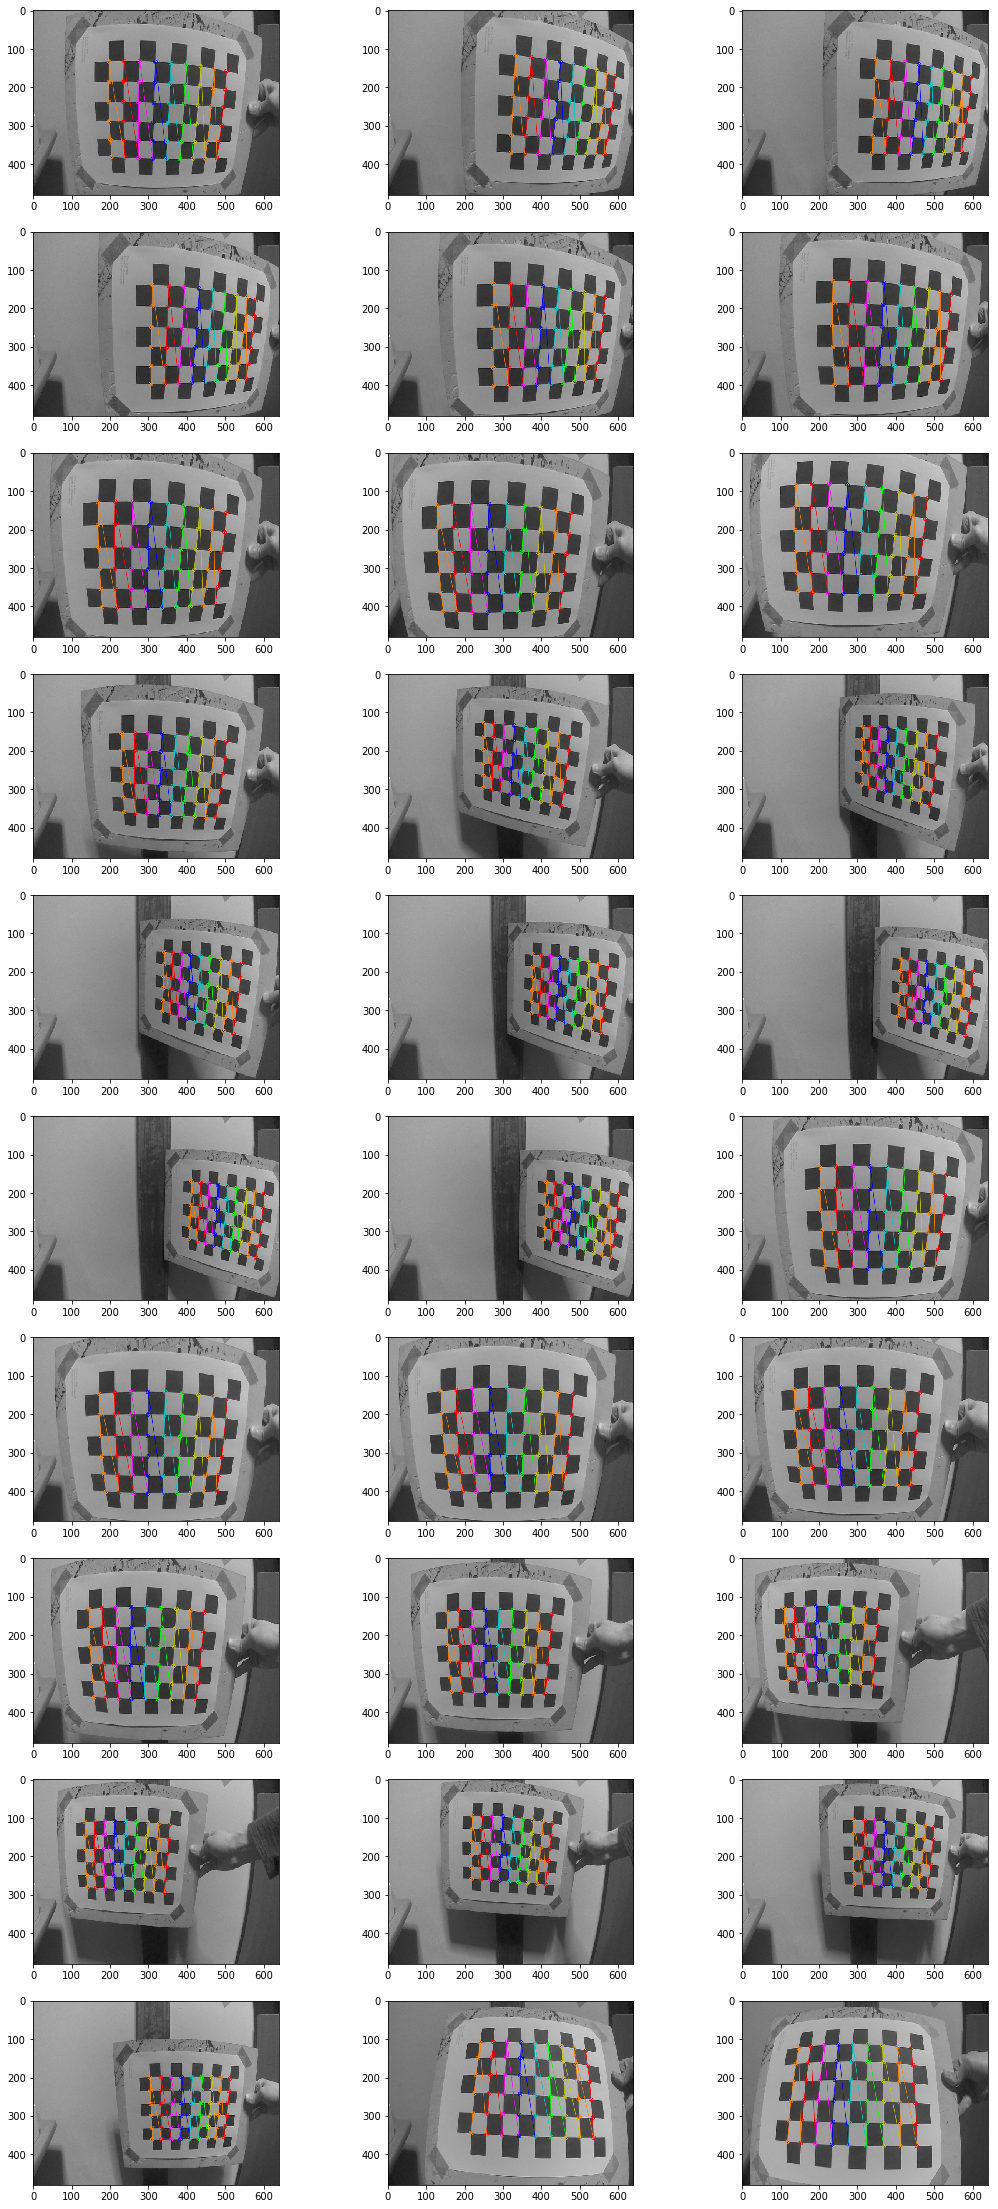

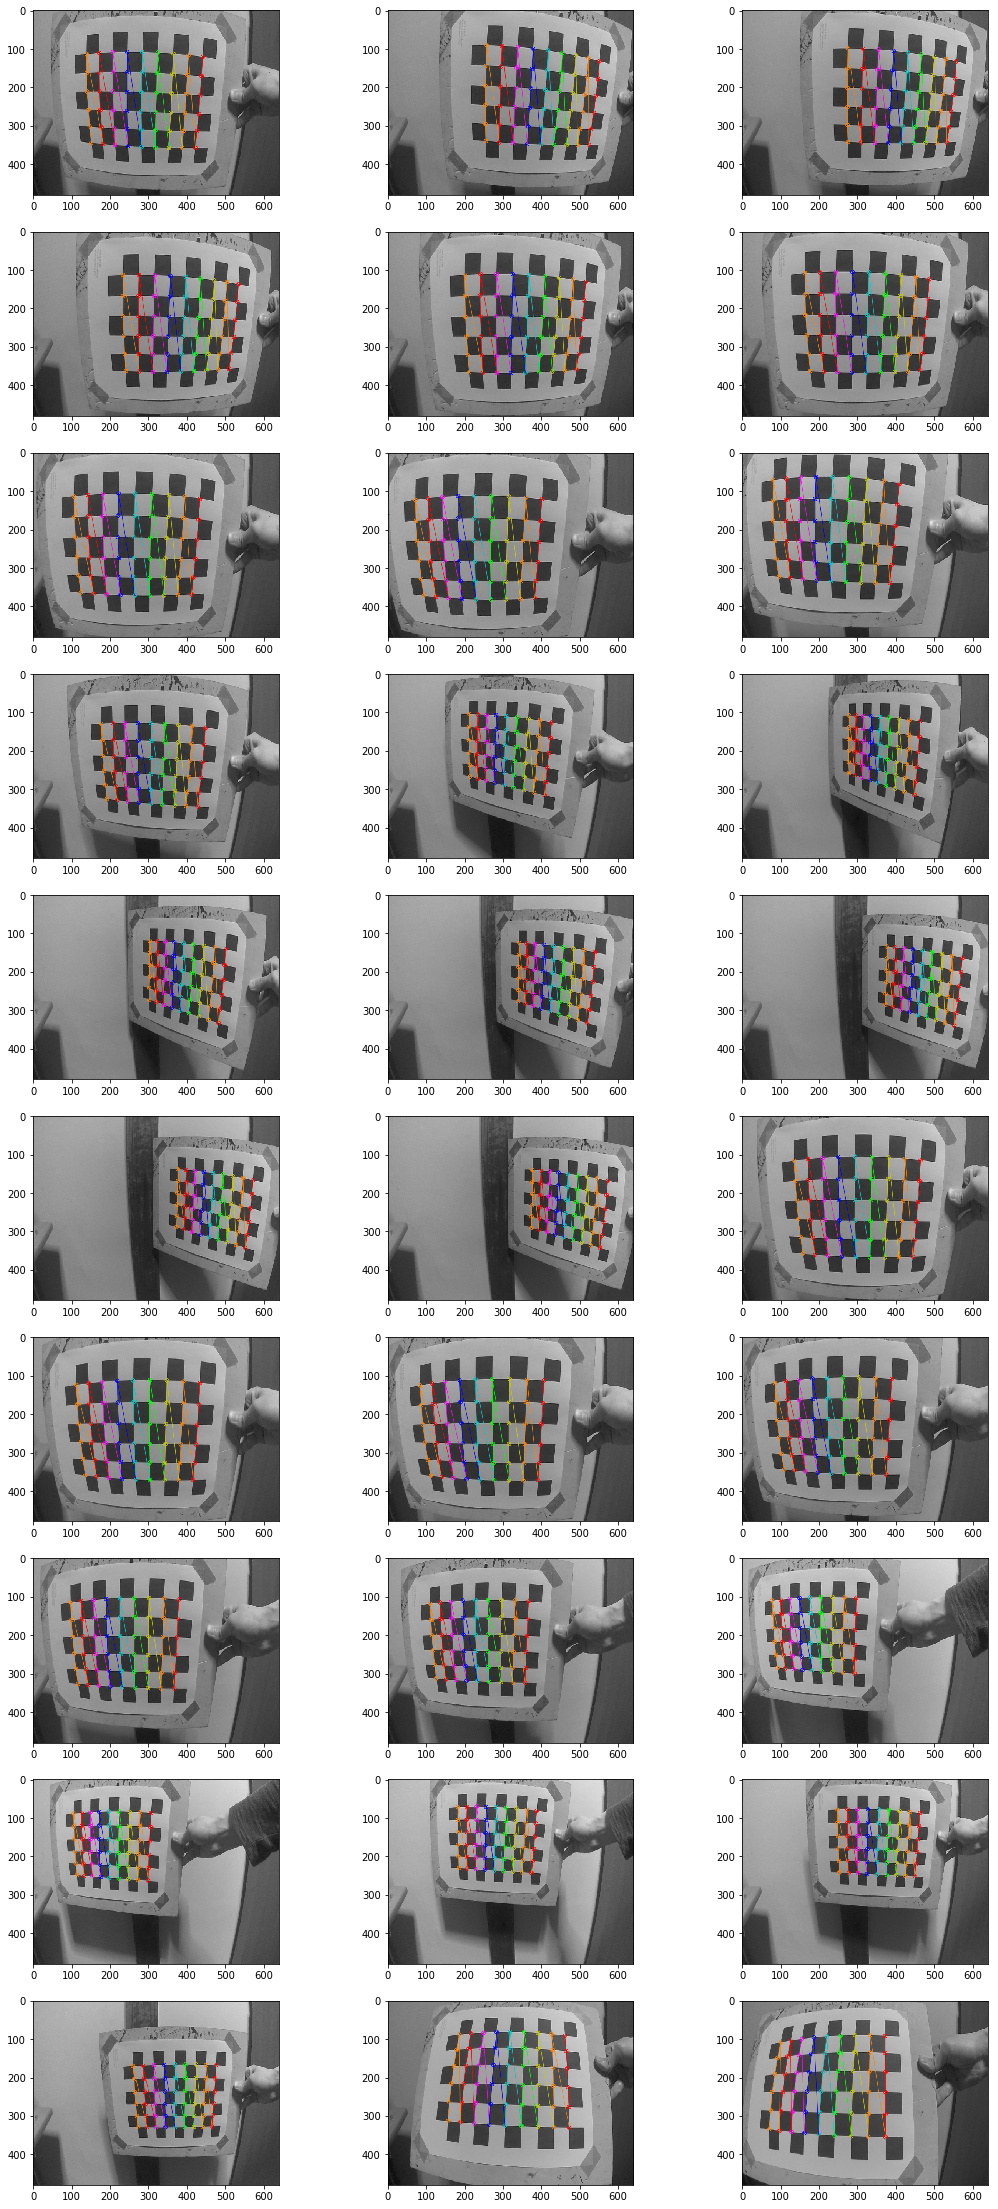

In [8]:
gridShow(imgs_l)
gridShow(imgs_r)

`undistort/undistort.ipynb`で作成したカメラパラメータを読み込み、ステレオカメラキャリブレーションの初期値に用います。

In [9]:
camera_param_l = np.load("../camera_param/camera_param_l.npz")
camera_param_r = np.load("../camera_param/camera_param_r.npz")
mtx_l, dist_l = [camera_param_l[i] for i in ["mtx_l", "dist_l"]]
mtx_r, dist_r = [camera_param_r[i] for i in ["mtx_r", "dist_r"]]

キャリブレーション用画像からカメラモデルを推定します。このカメラモデルにカメラの歪み具合などの情報が含まれており、歪み補正に使用します。ステレオカメラの場合は左右のカメラの位置関係も同時に推定します。
* カメラモデルのパラメータ(`_l`が末尾につくものは左カメラ、`_r`は右カメラです)
    * `mtx`: カメラの内部パラメータ行列
    * `dist`: 歪み係数のベクトル(ここではk_1, k_2, p_1, p_2)
    * `R`: カメラ座標系間の回転行列
    * `T`: カメラ座標系間の並進ベクトル
    * `E`: 基本行列: カメラ座標系（3次元）におけるエピポーラ拘束を示すのに用いる
    * `F`: 基礎行列: 画像座標系（2次元）におけるエピポーラ拘束を示すのに用いる


In [10]:
h, w = img_l.shape[:2]

newmtx_l, roi_l = cv2.getOptimalNewCameraMatrix(mtx_l, dist_l, (w,h), 1, (w,h))
newmtx_r, roi_r = cv2.getOptimalNewCameraMatrix(mtx_r, dist_r, (w,h), 1, (w,h))

ret, mtx_l, dist_l, mtx_r, dist_r, R, T, E, F = \
    cv2.stereoCalibrate(
        object_points,
        img_points_l,
        img_points_r,
        newmtx_l,
        dist_l,
        newmtx_r,
        dist_r,
        (w,h),
        flags=0
    )

作成したステレオカメラモデルを保存します。

In [11]:
np.savez('../camera_param/camera_param.npz',
    mtx_l=mtx_l,
    dist_l=dist_l,
    mtx_r=mtx_r,
    dist_r=dist_r,
    R=R,
    T=T,
    E=E,
    F=F
)

歪みを補正したカメラモデルを作成し、画像の歪み補正を行います。左が補正前、右が補正後です。チェスボードのマス目がまっすぐになっていれば正常に歪み補正がされています。

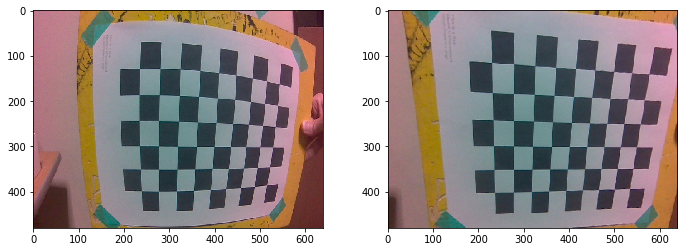

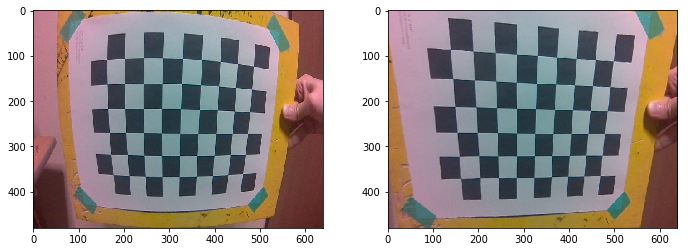

In [12]:
img_l = cv2.imread(imgs_dir_l[5])
img_r = cv2.imread(imgs_dir_r[5])

undistorted_img_l = cv2.undistort(img_l, mtx_l, dist_l, None)
undistorted_img_r = cv2.undistort(img_r, mtx_r, dist_r, None)

gridShow([img_l, undistorted_img_l])
gridShow([img_r, undistorted_img_r])

## 視差画像作成
ステレオ画像を用いて視差画像を作成します。視差とはカメラ位置の違いによって物体が見える方向に生じる差のことです。人間も左右交互に片目ずつ景色を見ると、それぞれの目に見える景色の位置関係が少し異なることに気づくと思います。

視差は遠いほど小さく、近いほど大きくなります。移動する電車の車窓から見える景色も近い景色ほど動きが大きく、遠い景色ほど動きが小さいことから実感できます。視差は左右の画像で共通点となる特徴(特徴点)を探し、その特徴が左右の画像上でどれだけずれているかを計算することで得られます。

次のステップでエピポーラ線を描画するために関数を作成します。

In [13]:
def drawEpipolarLine(img):
    i = 0
    h, w = img.shape[:2]
    for i in range(10):
        y = h*i//10
        epipolar_img = cv2.line(img, (0, y), (w, y), (0, 0, 255), 2)
    return epipolar_img

視差画像を推定するためにステレオ平行化を行います。ステレオ平行化を簡単に説明すると左右の画像の高さをそろえることです。高さがそろうことで視差を求める際、同じ高さに写る特徴点同士を比べるだけで済むため計算が楽になります。厳密な定義ではありませんが、ある特徴点と同じ高さの線をエピポーラ線といいます。同じ高さの特徴点を比べるということはエピポーラ線上の特徴点を比べるということになります。

まずはステレオ平行化に必要なパラメータを取得します。
* `Rp`: ステレオ平行化のために修正されたカメラ座標から見た元のカメラ座標の姿勢
* `Pp`: 修正されたカメラ座標系から画像座標系への射影変換行列
* `Q`: 視差画像を深度画像へマッピングするための行列

In [14]:
Rp_l, Rp_r, Pp_l, Pp_r, Q, validpixROI_l, validpixROI_r = \
    cv2.stereoRectify(
        mtx_l, dist_l, mtx_r, dist_r, (w,h), R, T
    )

次にステレオ平行化と歪み補正を行います。左右の画像で被写体の高さが合っているか確認してください。ロボットと同じようにエピポーラ線(横向きの赤い線)を目印に見比べるとわかりやすいです。

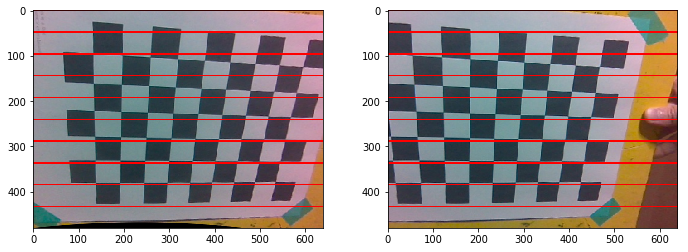

In [15]:
map4p_l = cv2.initUndistortRectifyMap(mtx_l, dist_l, Rp_l, Pp_l, (w,h), cv2.CV_32FC1)
map4p_r = cv2.initUndistortRectifyMap(mtx_r, dist_r, Rp_r, Pp_r, (w,h), cv2.CV_32FC1)

rectified_img_l = cv2.remap(img_l, map4p_l[0], map4p_l[1], cv2.INTER_LINEAR)    
rectified_img_r = cv2.remap(img_r, map4p_r[0], map4p_r[1], cv2.INTER_LINEAR)

epipolar_img_l = drawEpipolarLine(rectified_img_l)
epipolar_img_r = drawEpipolarLine(rectified_img_r)

gridShow([epipolar_img_l, epipolar_img_r])

### Block Matchingによる視差計算
ステレオマッチングの手法の一つにブロックマッチング法があります。これはテンプレートマッチングの一種で、基準画像ともう一方の画像内から最も類似した箇所を検出するものです。

<details>
<summary><h4> ✍ テンプレートマッチングの類似度計算について詳しくはこちらをクリックして解説をご覧ください</h4></summary>

テンプレートマッチングでは類似度の計算にSSD（Sun of Squared Difference）やSAD（Sum of Absolute Difference）などが使われています。OpenCVの実装ではSADを元に類似度を決定しています。


$
R_{SSD} = \Sigma^{N-1}_{j=0} \Sigma^{M-1}_{i=0} (I(i,j)-T(i,j))^2
$

$
R_{SAD} = \Sigma^{N-1}_{j=0} \Sigma^{M-1}_{i=0} |I(i,j)-T(i,j)|
$

</details>

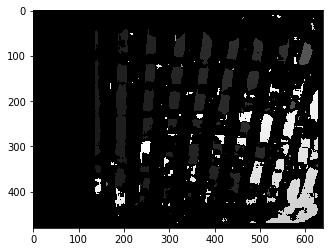

In [16]:
window_size = 21 # 大きめに設定する
num_disp = 128 # 最大視差
stereo = cv2.StereoBM_create(num_disp, window_size)

rectified_grayimg_l = cv2.cvtColor(rectified_img_l, cv2.COLOR_BGR2GRAY)
rectified_grayimg_r = cv2.cvtColor(rectified_img_r, cv2.COLOR_BGR2GRAY)

disparity = stereo.compute(rectified_grayimg_l, rectified_grayimg_r)
plt.imshow(disparity, cmap='gray')

### Semi-Global Block Matchingによる視差計算
ブロックマッチング法では単純に左右画像で類似度の計算を行っているため、滑らかな視差画像が得られない場合が多いです。物体は連続している場合が多いことから、視差の滑らかさを考慮したセミグローバルブロックマッチング法を用いることで視差画像はより滑らかなものとなります。視差画像が滑らかになる一方で計算コストが増加するため、リアルタイム性を求められるプログラムに使用する場合は注意する必要があります。

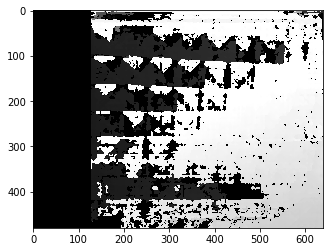

In [17]:
min_disp = 0
window_size = 5
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,
    numDisparities = 128,
    blockSize = window_size,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 5,
    speckleWindowSize = 100,
    speckleRange = 32
)

rectified_grayimg_l = cv2.cvtColor(rectified_img_l, cv2.COLOR_BGR2GRAY)
rectified_grayimg_r = cv2.cvtColor(rectified_img_r, cv2.COLOR_BGR2GRAY)

disparity = stereo.compute(rectified_grayimg_l, rectified_grayimg_r) / 16
plt.imshow(disparity, cmap='gray')

### 三次元復元
ステレオ平行化の際に得られた$Q$行列と視差画像を元に三次元点位置の計算が可能となります。
式に表すと
\begin{equation}
Q \cdot
\begin{bmatrix}
u, v, d, 1
\end{bmatrix}
=
\begin{bmatrix}
X, Y, Z, W
\end{bmatrix}
\end{equation}

\begin{equation}
\begin{bmatrix}
x, y, z
\end{bmatrix}
=
\begin{bmatrix}
X, Y, Z
\end{bmatrix}
/W
\end{equation}
となります。$u$、$v$は画像上での対応点の位置、$d$は対応点の視差$x$、$y$、$z$が三次元空間上での対応点の位置です。($x$、$y$、$z$の座標系はステレオ平行化によって修正されたカメラ座標系となります。)

下記にある一点における計算の例を挙げます。

In [ ]:
print(Q)
position = Q@np.array([[200],[200],[224],[1]])

X = position[0]/position[3]
Y = position[1]/position[3]
Z = position[2]/position[3]

print("点位置")
print(X, Y, Z)

視差画像から三次元点群を作成します。

In [19]:
point_cloud = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q, handleMissingValues=False)

作成した点群を保存します。CloudCompare等のソフトで閲覧できます。

* [CloudCompare - Open Source project](https://www.danielgm.net/cc/)

In [20]:
colors = cv2.cvtColor(rectified_img_l,cv2.COLOR_BGR2RGB)

# 最小視差より大きな値のみで作成
mask = disparity > 0
point_cloud[point_cloud==float('inf')] = 0
point_cloud[point_cloud==float('-inf')] = 0

verts= point_cloud[mask]
colors = colors[mask]

ply_header = '''ply
format ascii 1.0
element vertex {}
property float x
property float y
property float z
property float red
property float green
property float blue
end_header
'''.format(str(verts.shape[0]))

verts = verts.reshape(-1, 3)
colors = colors.reshape(-1, 3)

verts = np.hstack([verts, colors/255.0])

file_name = 'point_cloud.ply'

with open(file_name, 'w') as f:
    f.write(ply_header)

with open(file_name, 'ab') as f:
    np.savetxt(f, verts, '%f %f %f %f %f %f')

## まとめ
ステレオカメラの位置関係をキャリブレーションし、視差推定と三次元復元によってカメラと撮影対象の距離を推定することができました。次のステップでは魚眼カメラモデルを用いた`undistort_fisheye.ipynb`によって広い画角を維持したままキャリブレーションを行います。